# I. INTRODUCTION

Name : Gheddi

Batch : RMT-022

Objective : This project aims to predict the purchase propensity of a customer in an online store. The purpose of the project is offer business the advantage of knowing when their customer are highly likely to order from the online store, so business can develop a profitable strategy on top of this. To achieve this purpose, 5 model will be compared and the best model will be evaluated using precision metric and auc score.

# II. IMPORT LIBRARIES

In [1]:
# essentials
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA, KernelPCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import matthews_corrcoef

# model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

# model saving
import joblib
import json

# Colab packages
from google.colab import auth
from google.cloud import bigquery
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## < Conceptual Problem >



1. **bagging is an ensemble method where it has multiple base classifier learning from different subset of data and the final prediction of bagging algorithm is the average or aggregated prediction of the different base classifier.** ~ https://www.ibm.com/topics/bagging

2. **Random forest which is a type of bagging algorithm is where the base learners learn independently from each other in parallel manner, while on the boosting algorithm the base learner learn in sequential like manner where newer base learner is influenced by the performance of previous base learner.** ~ https://www.educba.com/random-forest-vs-gradient-boosting/

3. **Cross-Validation is a tool to evaluate machine learning models by training a model on different subsets of the input data and measure how good the model generalize on new unseen data.** ~ https://www.kdnuggets.com/2022/07/kfold-cross-validation.html

# III. DATA LOADING

In [2]:
df_original = pd.read_csv('/content/drive/MyDrive/# Hacktiv8 Data Science/Milestone/propensity.csv')

In [3]:
df = df_original.copy()

# IV. EXPLORATORY DATA ANALYSIS

1. check column names and data types

almost all column are numerical

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455401 entries, 0 to 455400
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   455401 non-null  object
 1   basket_icon_click        455401 non-null  int64 
 2   basket_add_list          455401 non-null  int64 
 3   basket_add_detail        455401 non-null  int64 
 4   sort_by                  455401 non-null  int64 
 5   image_picker             455401 non-null  int64 
 6   account_page_click       455401 non-null  int64 
 7   promo_banner_click       455401 non-null  int64 
 8   detail_wishlist_add      455401 non-null  int64 
 9   list_size_dropdown       455401 non-null  int64 
 10  closed_minibasket_click  455401 non-null  int64 
 11  checked_delivery_detail  455401 non-null  int64 
 12  checked_returns_detail   455401 non-null  int64 
 13  sign_in                  455401 non-null  int64 
 14  saw_checkout        

2. check a subset of the data

the columns seems to be binary

In [ ]:
df.sample(5)

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
125851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
55279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
101956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
372647,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
171520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0


3. checking duplicates

no duplicates on the dataset

In [6]:
df.duplicated().sum()

0

4. checking missing value

no missing values in every column

In [69]:
df.isna().sum()

UserID                     0
basket_icon_click          0
basket_add_list            0
basket_add_detail          0
sort_by                    0
image_picker               0
account_page_click         0
promo_banner_click         0
detail_wishlist_add        0
list_size_dropdown         0
closed_minibasket_click    0
checked_delivery_detail    0
checked_returns_detail     0
sign_in                    0
saw_checkout               0
saw_sizecharts             0
saw_delivery               0
saw_account_upgrade        0
saw_homepage               0
device_mobile              0
device_computer            0
device_tablet              0
returning_user             0
loc_uk                     0
ordered                    0
dtype: int64

5. descriptive statistic of the dataset

no negative values, all columns values range between 0 and 1 only, the columns seems to be imbalanced need further plotting

In [68]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
basket_icon_click,455401.0,0.099150,0.298864,0.0,0.0,0.0,0.0,1.0
basket_add_list,455401.0,0.074521,0.262617,0.0,0.0,0.0,0.0,1.0
basket_add_detail,455401.0,0.112916,0.316490,0.0,0.0,0.0,0.0,1.0
sort_by,455401.0,0.036849,0.188391,0.0,0.0,0.0,0.0,1.0
image_picker,455401.0,0.026735,0.161307,0.0,0.0,0.0,0.0,1.0
account_page_click,455401.0,0.003570,0.059647,0.0,0.0,0.0,0.0,1.0
promo_banner_click,455401.0,0.016208,0.126274,0.0,0.0,0.0,0.0,1.0
detail_wishlist_add,455401.0,0.003511,0.059151,0.0,0.0,0.0,0.0,1.0
list_size_dropdown,455401.0,0.230362,0.421065,0.0,0.0,0.0,0.0,1.0
closed_minibasket_click,455401.0,0.017277,0.130302,0.0,0.0,0.0,0.0,1.0


6. checking the cardinality of each column

after checking cardinality its clear that all numerical values are binary

In [8]:
df_cardinality = df.drop('UserID', axis=1)
for col in df_cardinality.columns:
  print(f'{col} column unique values : {df_cardinality[col].unique()}')

basket_icon_click column unique values : [0 1]
basket_add_list column unique values : [0 1]
basket_add_detail column unique values : [0 1]
sort_by column unique values : [0 1]
image_picker column unique values : [0 1]
account_page_click column unique values : [0 1]
promo_banner_click column unique values : [0 1]
detail_wishlist_add column unique values : [0 1]
list_size_dropdown column unique values : [0 1]
closed_minibasket_click column unique values : [0 1]
checked_delivery_detail column unique values : [1 0]
checked_returns_detail column unique values : [0 1]
sign_in column unique values : [0 1]
saw_checkout column unique values : [0 1]
saw_sizecharts column unique values : [0 1]
saw_delivery column unique values : [0 1]
saw_account_upgrade column unique values : [0 1]
saw_homepage column unique values : [0 1]
device_mobile column unique values : [1 0]
device_computer column unique values : [0 1]
device_tablet column unique values : [0 1]
returning_user column unique values : [0 1]


7. correlation heatmap

the feature that are highly correlated to the target variable are checked delivery detail, sign in, and saw checkout

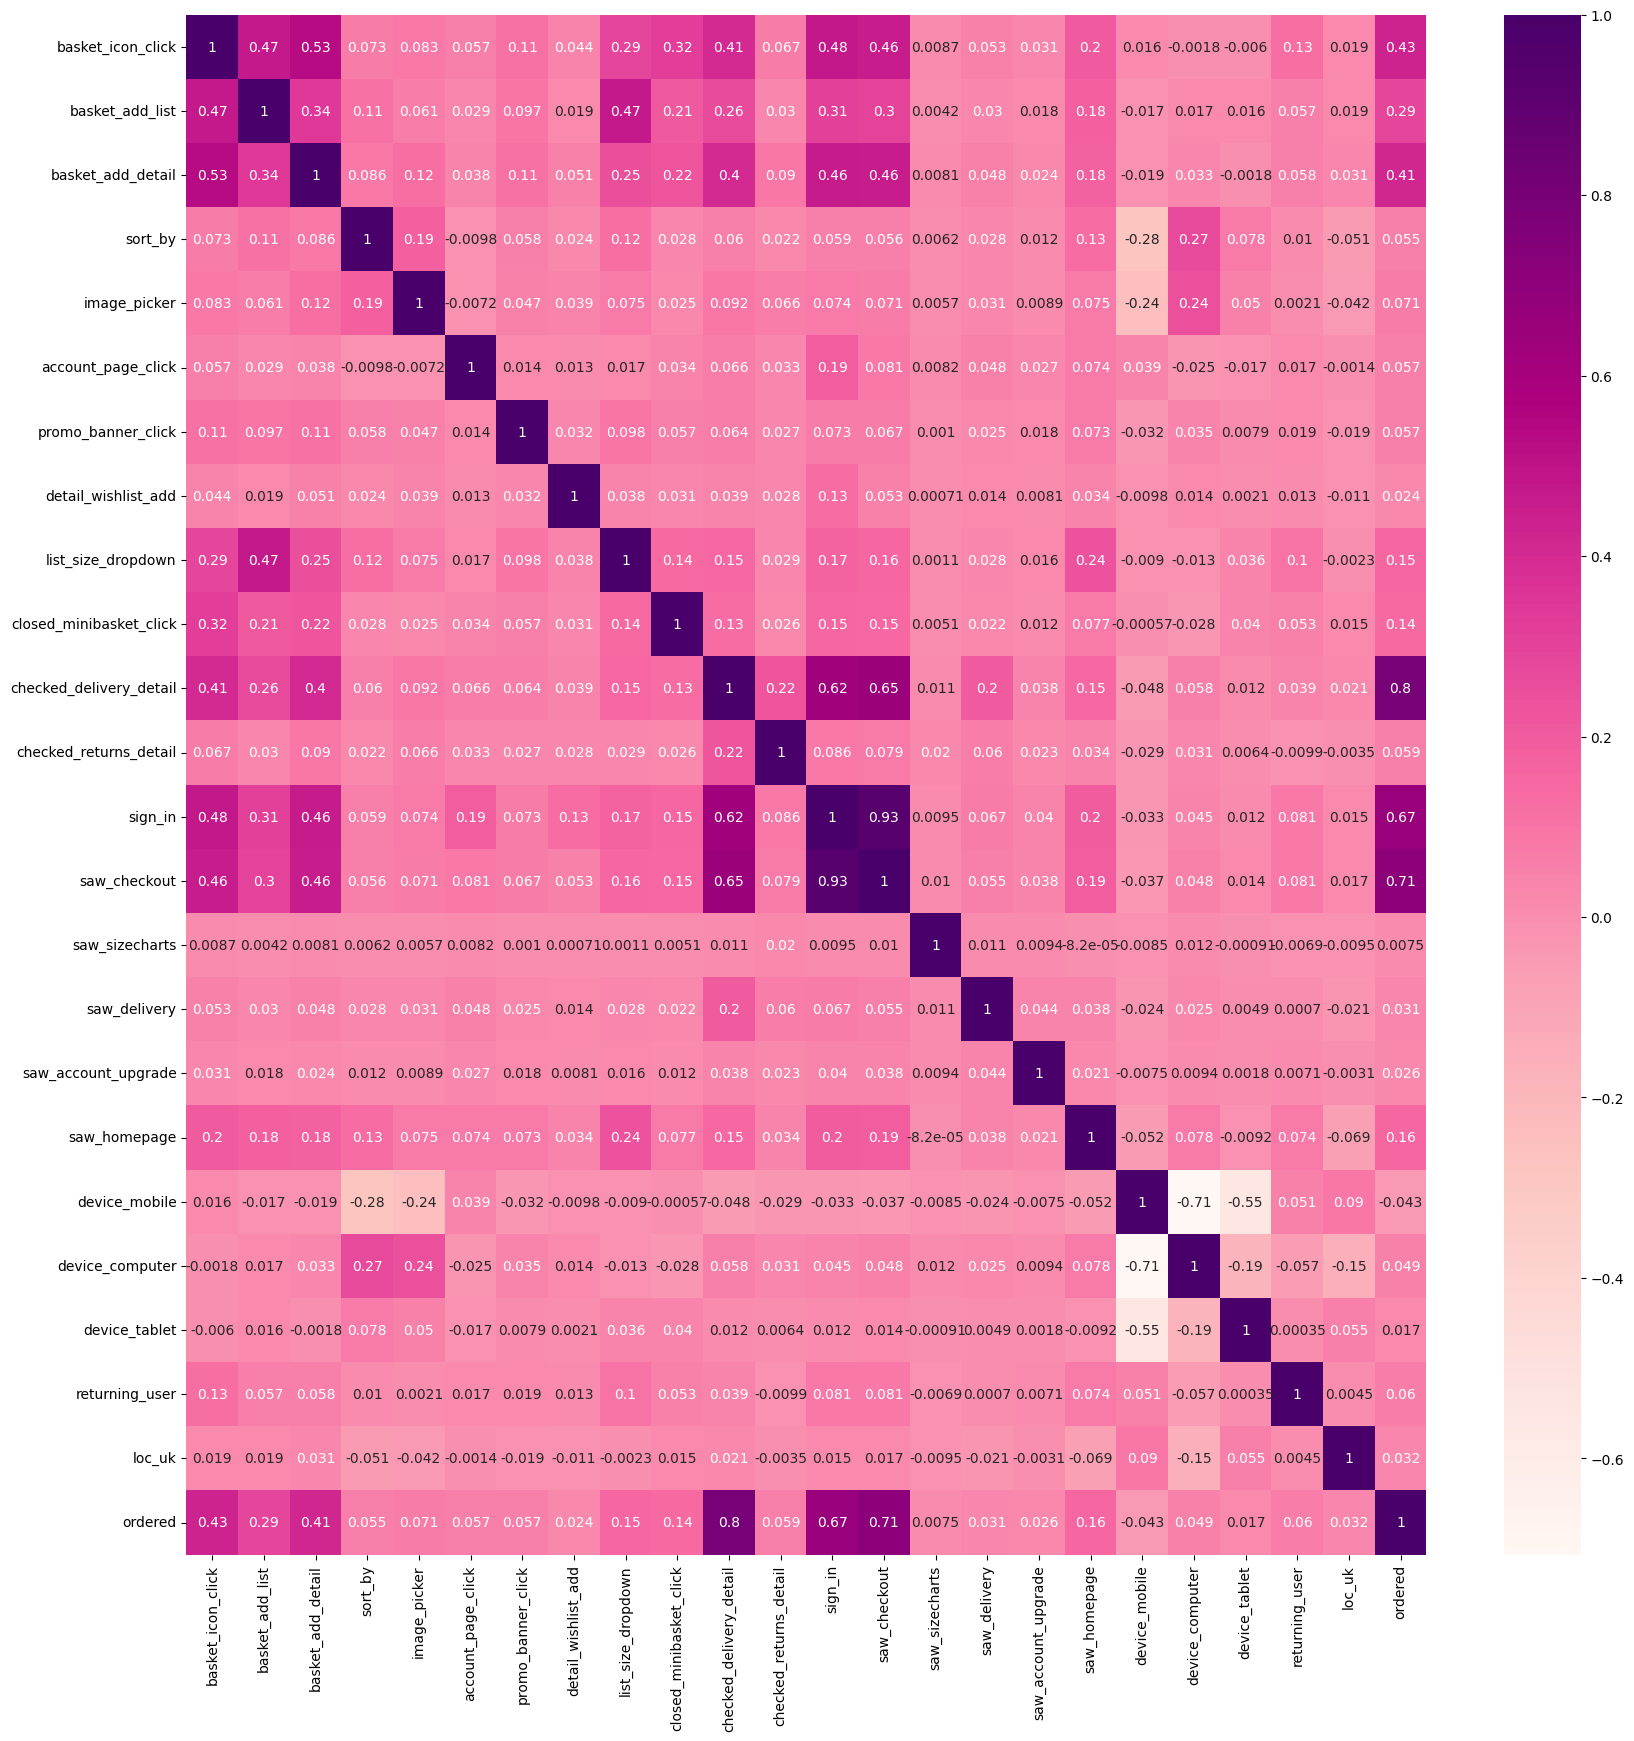

In [66]:
df_corr=df.corr()

plt.figure(figsize = (20, 20))
sns.heatmap(df_corr,annot=True,cmap='RdPu')
plt.show()

8. check the balance of target variable

the class on the target variable is highly imbalanced

<Axes: >

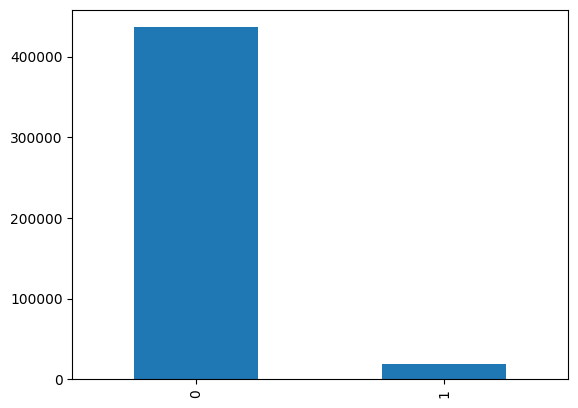

In [67]:
df['ordered'].value_counts().plot(kind='bar')

9. distribution of all columns

almost every column are imbalanced

array([[<Axes: title={'center': 'basket_icon_click'}>,
        <Axes: title={'center': 'basket_add_list'}>,
        <Axes: title={'center': 'basket_add_detail'}>,
        <Axes: title={'center': 'sort_by'}>,
        <Axes: title={'center': 'image_picker'}>],
       [<Axes: title={'center': 'account_page_click'}>,
        <Axes: title={'center': 'promo_banner_click'}>,
        <Axes: title={'center': 'detail_wishlist_add'}>,
        <Axes: title={'center': 'list_size_dropdown'}>,
        <Axes: title={'center': 'closed_minibasket_click'}>],
       [<Axes: title={'center': 'checked_delivery_detail'}>,
        <Axes: title={'center': 'checked_returns_detail'}>,
        <Axes: title={'center': 'sign_in'}>,
        <Axes: title={'center': 'saw_checkout'}>,
        <Axes: title={'center': 'saw_sizecharts'}>],
       [<Axes: title={'center': 'saw_delivery'}>,
        <Axes: title={'center': 'saw_account_upgrade'}>,
        <Axes: title={'center': 'saw_homepage'}>,
        <Axes: title={'cente

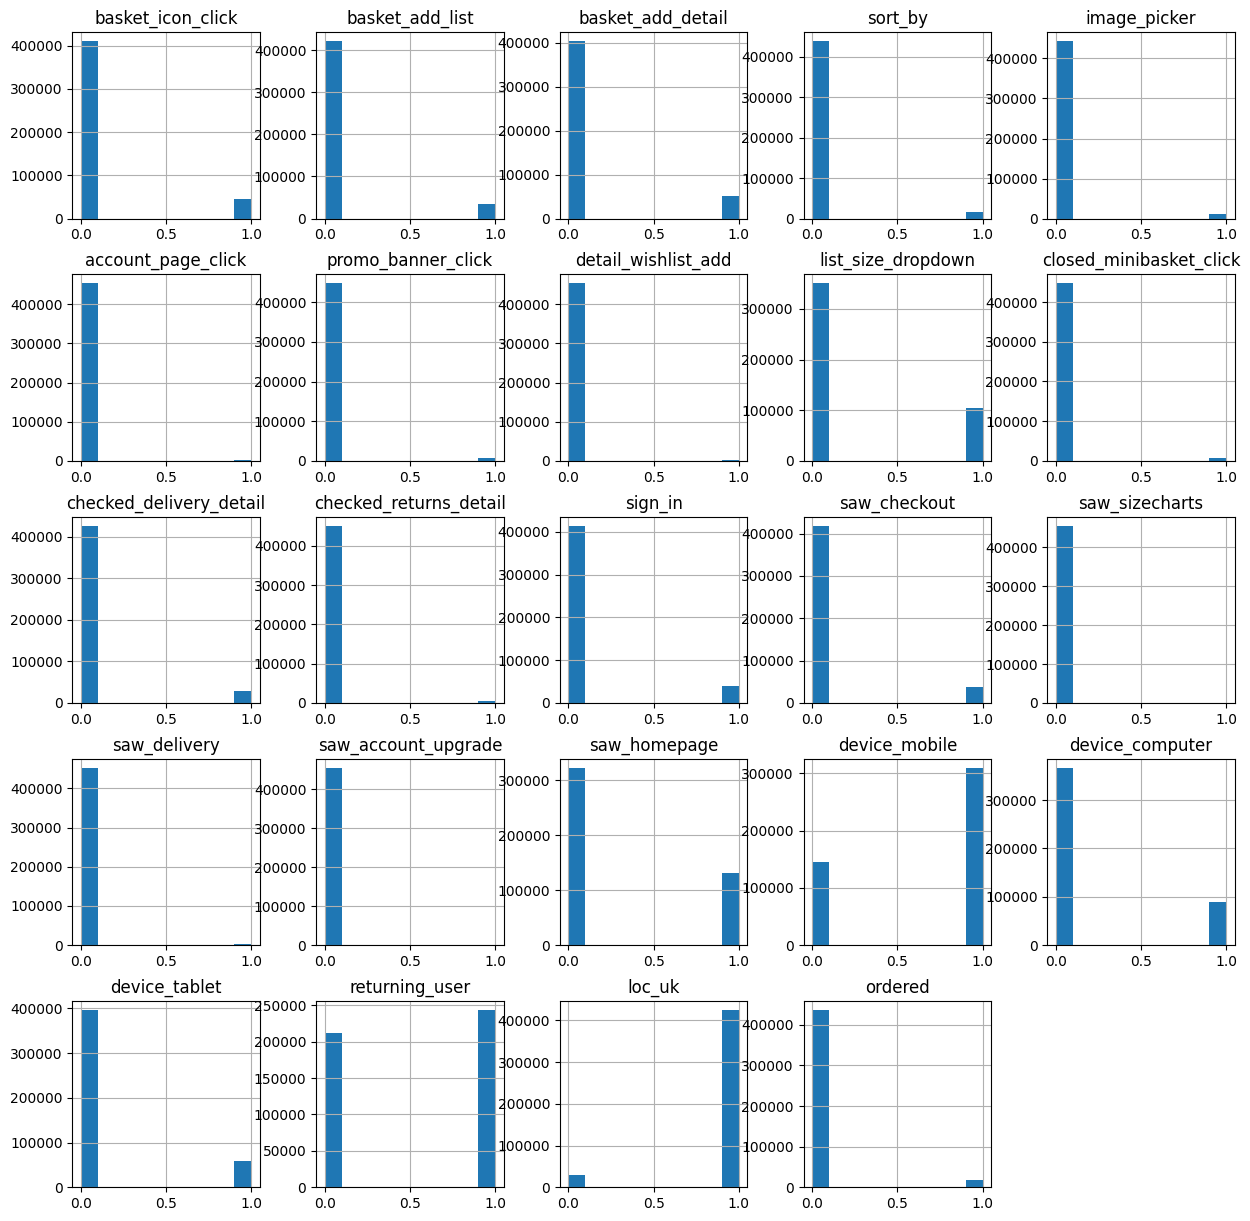

In [65]:
df.hist(figsize=(15, 15))

10. contingency table of the most correlated variable to the target variable

we want to focus on the right bottom side of the column where the probability of people who checked delivery detail (1 vertical axis) have a probability of 65% likely going to order (18896/(9737+18896)).


In [76]:
data_crosstab = pd.crosstab(df['checked_delivery_detail'],df['ordered'], margins = False)
print(data_crosstab)

ordered                       0      1
checked_delivery_detail               
0                        426571    197
1                          9737  18896


11. contingency table of the most uncorrelated feature to target variable

the likelihood of people saw account upgrade to order is only 19% (99/(400+99))

In [74]:
data_crosstab = pd.crosstab(df['saw_account_upgrade'],df['ordered'], margins = False)
print(data_crosstab)

ordered                   0      1
saw_account_upgrade               
0                    435908  18994
1                       400     99


# V. FEATURE ENGINEERING

### < Splitting Data >

In [4]:
# split data to train set and test set
train, test = train_test_split(df, test_size= 0.2,random_state=5)

In [5]:
# separate feature and target
X_train = train.drop('ordered',axis=1)
Y_train = train['ordered']
X_test = test.drop('ordered',axis=1)
Y_test = test['ordered']

In [6]:
# drop unused feature
X_train.drop('UserID', axis=1, inplace=True)
print(f'Train set shape : {X_train.shape}')
print('Total amount of each class of the target :')
print(Y_train.value_counts())

Train set shape : (364320, 23)
Total amount of each class of the target :
0    349045
1     15275
Name: ordered, dtype: int64


In [7]:
# use smote to create oversampled train set for future comparison
smote = SMOTE(random_state=33)
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)

In [8]:
print(f'Oversampled train set shape : {X_train_oversampled.shape}')
print('Total amount of each class of the target :')
print(Y_train_oversampled.value_counts())

Oversampled train set shape : (698090, 23)
Total amount of each class of the target :
0    349045
1    349045
Name: ordered, dtype: int64


### < Checking Multicollinearity >

In [25]:
# using VIF score to measure multicollinearity between variable
# the majority of columns are not displaying sign of multicollinearity
df_float = df.drop('UserID', axis=1).astype(float)

vif_data = pd.DataFrame()
vif_data["feature"] = df_float.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_float.values, i) for i in range(len(df_float.columns))]

vif_data

,feature,VIF
0,basket_icon_click,2.053465
1,basket_add_list,1.676683
2,basket_add_detail,1.782741
3,sort_by,1.185455
4,image_picker,1.138845
5,account_page_click,1.130253
6,promo_banner_click,1.042686
7,detail_wishlist_add,1.067372
8,list_size_dropdown,1.765511
9,closed_minibasket_click,1.151323


### < Feature Selection >

In [ ]:
# The author set a personal threshold for coefficient at 0.5 from referencing multiple source
# only three columns passed the threshold
y_var = train['ordered']
for col in train.columns:
  print(f'{col} correlation coefficient : {matthews_corrcoef(train[col], y_var)}')

basket_icon_click correlation coefficient : 0.4282882866506242
basket_add_list correlation coefficient : 0.29056891574439087
basket_add_detail correlation coefficient : 0.4141452939565644
sort_by correlation coefficient : 0.05494404181173775
image_picker correlation coefficient : 0.07148593886340297
account_page_click correlation coefficient : 0.05666650702014135
promo_banner_click correlation coefficient : 0.05752439381722766
detail_wishlist_add correlation coefficient : 0.0245152570459411
list_size_dropdown correlation coefficient : 0.15646119181609236
closed_minibasket_click correlation coefficient : 0.1397486901907454
checked_delivery_detail correlation coefficient : 0.7987950561645234
checked_returns_detail correlation coefficient : 0.06065483957799535
sign_in correlation coefficient : 0.6666823812405375
saw_checkout correlation coefficient : 0.7101755268357881
saw_sizecharts correlation coefficient : 0.006327965955791566
saw_delivery correlation coefficient : 0.031489462824954205

In [9]:
selected_feature = ['checked_delivery_detail', 'sign_in', 'saw_checkout']

In [11]:
X_train = X_train[selected_feature]

In [12]:
X_train.shape

(364320, 3)

### < Encoding >

all variable are already numerical, no further encoding

### < Outlier Handling >

no outlier because all feature columns are categorical variable

### < Normalization >

No normalization because no outlier in categorical variables

### < Building Column Transformer >

In [13]:
input_transformer = ColumnTransformer(
  transformers=[
    ("select necessary feature", 'passthrough', ['checked_delivery_detail', 'sign_in', 'saw_checkout'])
  ],
  remainder = 'drop'
)

# VI. MODEL DEFINITION

< KNN Model >

In [14]:
model_knn = KNeighborsClassifier()

< SVM >

In [15]:
model_svm = SVC()

< Decision Tree >

In [16]:
model_dtree = DecisionTreeClassifier()

< Random Forest >

In [17]:
model_rf = RandomForestClassifier()

< Boosting >

In [18]:
model_xgb = XGBClassifier()

# VII. MODEL TRAINING

 **to evaluate all baseline model the author is using cross validation method with precision as scoring option**

In [19]:
# the number of fold is set to 5
k_folds = KFold(n_splits = 5, shuffle=True)

### < KNN Model Training

In [20]:
knn_score = cross_val_score(model_knn, X_train, Y_train, cv = k_folds, scoring='precision') #scoring mmetric prec

In [22]:
print("KNN Cross Validation Scores: ", knn_score)
print("KNN Average CV Score: ", knn_score.mean())

KNN Cross Validation Scores:  [0.85758865 0.86033682 0.86261068 0.86612176 0.87087518]
KNN Average CV Score:  0.8635066181751204


### < SVM Model Training >

In [21]:
svm_score = cross_val_score(model_svm, X_train, Y_train, cv = k_folds, scoring='precision')

In [23]:
print("SVM Cross Validation Scores: ", svm_score)
print("SVM Average CV Score: ", svm_score.mean())

SVM Cross Validation Scores:  [0.86484952 0.86231884 0.85763589 0.86303304 0.8696271 ]
SVM Average CV Score:  0.8634928783539234


### < Decision Tree Model Training >

In [24]:
dtree_score = cross_val_score(model_dtree, X_train, Y_train, cv = k_folds, scoring='precision')

In [25]:
print("Decision Tree Cross Validation Scores: ", dtree_score)
print("Decision Tree Average CV Score: ", dtree_score.mean())

Decision Tree Cross Validation Scores:  [0.85228909 0.87144482 0.86148649 0.86134934 0.87095843]
Decision Tree Average CV Score:  0.8635056338873633


### < Random Forest Model Training >

In [26]:
rf_score = cross_val_score(model_rf, X_train, Y_train, cv = k_folds, scoring='precision')

In [27]:
print("Random Forest Cross Validation Scores: ", rf_score)
print("Random forest Average CV Score: ", rf_score.mean())

Random Forest Cross Validation Scores:  [0.86201022 0.8656286  0.87393768 0.85690188 0.85901926]
Random forest Average CV Score:  0.8634995301919901


### < XGBoost Model Training >

In [28]:
xgb_score = cross_val_score(model_xgb, X_train, Y_train, cv = k_folds, scoring='precision')

In [29]:
print("XGBoost Cross Validation Scores: ", xgb_score)
print("XGBoost forest Average CV Score: ", xgb_score.mean())

XGBoost Cross Validation Scores:  [0.85990474 0.85493119 0.8650201  0.86635541 0.87135991]
XGBoost forest Average CV Score:  0.8635142707389567


***After training all the baseline model with precision as the evaluation metric, XGBoost comes out as the best performing model based on the average cross validation score.***

### < Hyperparameter Tuning the Best Model >

after comparing 5 baseline model, we perform hyperparameter tuning on the best model

In [ ]:
xgb_params = {
    'booster': ['gbtree', 'gblinear'],
    'max_depth': [ 4, 5],
    'min_child_weight': [5, 10],
    'lambda': [1,2],
    'gamma': [0.5, 1],
    'subsample': [0.4, 0.8]
}

gridscv = GridSearchCV(model_xgb, param_grid=xgb_params, cv=5)
gridscv.fit(X_train, Y_train)

gridscv.best_params_

In [40]:
gridscv.best_params_

{'booster': 'gbtree',
 'gamma': 0.5,
 'lambda': 1,
 'max_depth': 4,
 'min_child_weight': 5,
 'subsample': 0.4}

In [46]:
# make pipeline containing column transformer
model_xgb_tuned = Pipeline(
  steps=[
    ("input processing", input_transformer),
    ("Decision Tree Model", XGBClassifier(booster='gbtree', gamma=0.5, reg_lambda=1, max_depth=4, min_child_weight=5, subsample=0.4))
  ]
)

model_xgb_tuned.fit(X_train, Y_train)

Pipeline(steps=[('input processing',
                 ColumnTransformer(transformers=[('select necessary feature',
                                                  'passthrough',
                                                  ['checked_delivery_detail',
                                                   'sign_in',
                                                   'saw_checkout'])])),
                ('Decision Tree Model',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_ca...
                               feature_types=None, gamma=0.5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

# VIII. MODEL EVALUATION

1. Accuracy : Accuracy measure the total correct prediction divide by the total number of predictions a model make. Accuracy can be misleading in imbalanced dataset. So its only viable on when the dataset is balanced

2. Precision : a metric that measures how often a model correctly predicts the positive class. It's used if we're looking to minimize False Positive to be as low as possible. Example of minimizing false positive is, when you dont want a model to misclassify a non employee as employee that can sneak inside a private building

3. Recall :  a metric that measures how often a model correctly identifies positive instances (True Positive) from all the actual positive samples in the dataset. It's used if we're looking to minimize False Negative to be as low as possible. Example of minimizing false negative is, when you dont want the model to falsely identify someone as healty but he/she actually carry a disease.

4. F1 Score : harmonic mean of precision and recall. The metric is useful if we were looking to minimize false positive and false negative at the same time.

* Accuracy, Precision, Recall, and F1 Score have scale : 0 - 1. The higher the value, the better.

### < Non Tuned Model Evaluation >

In [77]:
model_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [49]:
Y_train_pred = model_xgb.predict(X_train)
Y_test_pred = model_xgb.predict(X_test[selected_feature])

print('Training Report for Decision Tree Model')
print(classification_report(Y_train, Y_train_pred))
print('------------------------------------------------------')

print('Testing Report for Decision Tree Model')
print(classification_report(Y_test, Y_test_pred))

Training Report for Decision Tree Model
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    349045
           1       0.86      0.99      0.92     15275

    accuracy                           0.99    364320
   macro avg       0.93      0.99      0.96    364320
weighted avg       0.99      0.99      0.99    364320

------------------------------------------------------
Testing Report for Decision Tree Model
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     87263
           1       0.86      0.99      0.92      3818

    accuracy                           0.99     91081
   macro avg       0.93      0.99      0.96     91081
weighted avg       0.99      0.99      0.99     91081



*ROC/AUC of the Untuned XGBoost*



In [85]:
# ROC AUC is a metric that quantifies the ability of a binary classifier to distinguish between positive and negative classes
y_pred_prob = model_xgb.predict_proba(X_test[selected_feature])[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob, pos_label=1)

roc_auc = roc_auc_score(Y_test, y_pred_prob)
roc_auc

0.9963694494897313

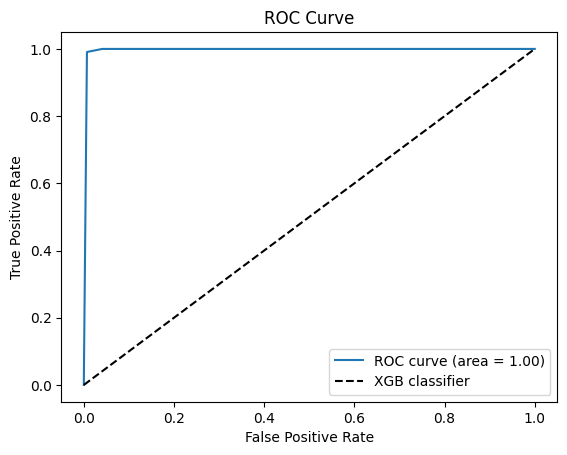

In [84]:
# ROC curve is the graphical representation of the effectiveness of the binary classification model.
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='XGB classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Interpreting the evaluation result of baseline XGBoost model** :

In our case, we want to focus on the ability of our model to correctly classify customers who're actually ordering so the relevant evaluation metric is precision on class 1 (customer made an order).

On the training set, the performance of the model is considerably good where it can be interpreted that our model are correct 86% of the time when predicting a customer who's actually going to order.

On the test set, the baseline model display an identical performance indicating its ability to generalize well on unseen data.

from the roc auc score and plot, its shown that the untuned XGBoost model did well on distinguishing the classes of the target variable.

to conclude, the baseline XGBoost model are viable even without performing additional tuning on the model.

### < Tuned Model Evaluation >

In [50]:
Y_train_pred = model_xgb_tuned.predict(X_train)
Y_test_pred = model_xgb_tuned.predict(X_test)

print('Training Report for Decision Tree Model')
print(classification_report(Y_train, Y_train_pred))
print('------------------------------------------------------')

print('Testing Report for Decision Tree Model')
print(classification_report(Y_test, Y_test_pred))

Training Report for Decision Tree Model
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    349045
           1       0.86      0.99      0.92     15275

    accuracy                           0.99    364320
   macro avg       0.93      0.99      0.96    364320
weighted avg       0.99      0.99      0.99    364320

------------------------------------------------------
Testing Report for Decision Tree Model
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     87263
           1       0.86      0.99      0.92      3818

    accuracy                           0.99     91081
   macro avg       0.93      0.99      0.96     91081
weighted avg       0.99      0.99      0.99     91081



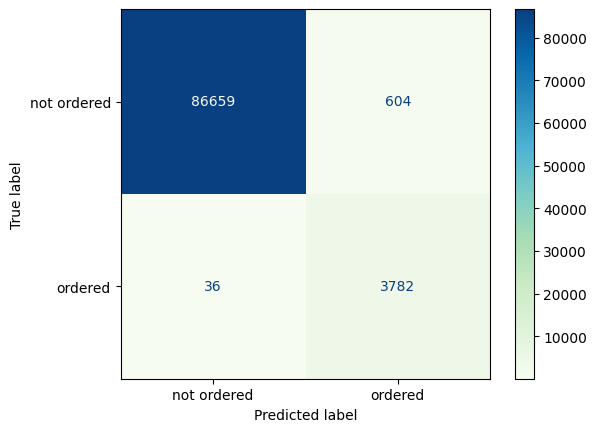

In [52]:
Y_test_pred = model_xgb_tuned.predict(X_test)
cm = confusion_matrix(Y_test, Y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not ordered', 'ordered'])
disp.plot(cmap='GnBu')
plt.show()

*ROC/AUC of the Tuned XGBoost*

In [86]:
# ROC AUC is a metric that quantifies the ability of a binary classifier to distinguish between positive and negative classes
y_pred_prob = model_xgb_tuned.predict_proba(X_test[selected_feature])[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob, pos_label=1)

roc_auc = roc_auc_score(Y_test, y_pred_prob)
roc_auc

0.9963694494897313

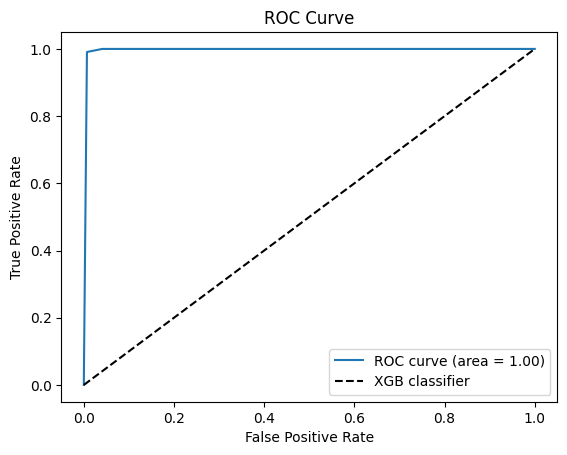

In [87]:
# ROC curve is the graphical representation of the effectiveness of the binary classification model.
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='XGB classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Interpreting the evaluation result of Tuned XGBoost model** :

During hyperparemeter tuning the author employ 64 set combination from 5 different parameters. On the training set, the performance of tuned model is considerably good where it can be interpreted that our model are correct 86% of the time when predicting a customer who's actually going to order. But this performance is not any better from the non-tuned model

On the test set, the baseline model also display an identical performance to the train set. The tuned model show a good generalization ability towards unseen data though this performance is not better than the untuned model. From the confusion matrix it can be seen that out of 4386 total prediction where the model predict a customer will order, the model is correct 3782 times and wrong 604 times. It signify that the model is correct 6 out of 7 times which is quite promising.

from the roc auc score and plot, its shown that the tuned XGBoost model did well on distinguishing the classes of the target variable.

to conclude, the tuned XGBoost model are viable but its not yielding a better performance compared to the baseline model.

### < Evaluating Tuned Model on oversampled data >

In [88]:
model_xgb_tuned.fit(X_train_oversampled, Y_train_oversampled)

Pipeline(steps=[('input processing',
                 ColumnTransformer(transformers=[('select necessary feature',
                                                  'passthrough',
                                                  ['checked_delivery_detail',
                                                   'sign_in',
                                                   'saw_checkout'])])),
                ('Decision Tree Model',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_ca...
                               feature_types=None, gamma=0.5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [62]:
Y_train_pred = model_xgb_tuned.predict(X_train_oversampled)
Y_test_pred = model_xgb_tuned.predict(X_test)

print('Training Report for XGBoost Model on oversampled data')
print(classification_report(Y_train_oversampled, Y_train_pred))
print('------------------------------------------------------')

print('Testing Report for XGBoost Model')
print(classification_report(Y_test, Y_test_pred))

Training Report for XGBoost Model on oversampled data
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    349045
           1       0.99      0.99      0.99    349045

    accuracy                           0.99    698090
   macro avg       0.99      0.99      0.99    698090
weighted avg       0.99      0.99      0.99    698090

------------------------------------------------------
Testing Report for XGBoost Model
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     87263
           1       0.85      0.99      0.91      3818

    accuracy                           0.99     91081
   macro avg       0.92      0.99      0.95     91081
weighted avg       0.99      0.99      0.99     91081



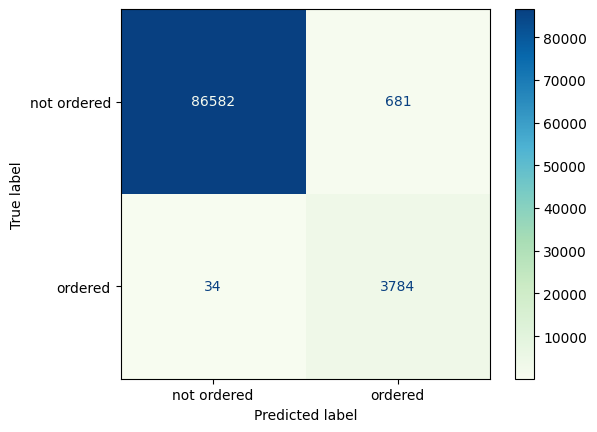

In [63]:
Y_test_pred = model_xgb_tuned.predict(X_test)
cm = confusion_matrix(Y_test, Y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not ordered', 'ordered'])
disp.plot(cmap='GnBu')#plt.cm.Blues
plt.show()

*ROC/AUC of XGBoost model on oversampled data*

In [89]:
# ROC AUC is a metric that quantifies the ability of a binary classifier to distinguish between positive and negative classes
y_pred_prob = model_xgb_tuned.predict_proba(X_test[selected_feature])[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob, pos_label=1)

roc_auc = roc_auc_score(Y_test, y_pred_prob)
roc_auc

0.9963694494897313

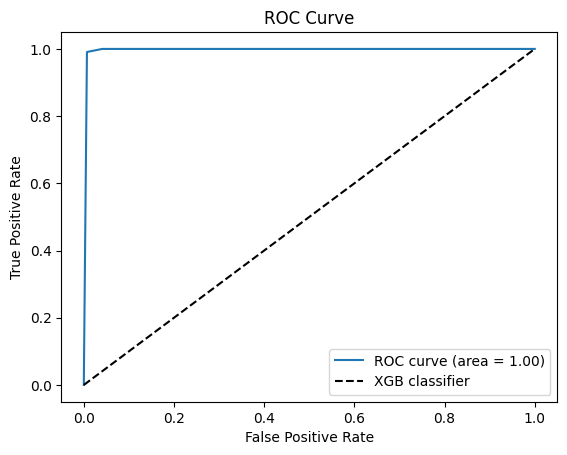

In [90]:
# ROC curve is the graphical representation of the effectiveness of the binary classification model.
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='XGB classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Interpreting the evaluation result of tuned XGBoost on oversampled data** :

to handle the class imbalance on the target variable the author fabricate an oversampled training data in hope that the model will learn better on this data. After training the model on oversampled data, the precision score result is astonishingly high at 99%. This signify that the model learn way better on oversampled data where there's no class imbalance on the target variable.

But the problem arise when we evaluate the model performance on test data. the precision score of the test set is only 85%, 14% lower compared to the performance on the train set. This indicate a possible overfitting, where the model doesnt generalize well towards new unseen data.

As addition from the roc auc score and plot, its shown that the tuned XGBoost model trained on oversampled data did well on distinguishing the classes of the target variable.

to conclude, the tuned XGBoost model that's trained on oversampled data shows sign of overfitting and considered to be non viable.

### < Overall Analysis >



1. the evaluation from different metrics shows that the baseline XGBoost model is viable with a ratio of correct prediction around 6 out of 7.

2. the strength of XGBoost model is its relatively fast to train, naturally good at mitigating overfitting, and able to achieve good performance. The result of ROC/AUC evaluation shows that the model did well on distinguishing the binary class of the target variable. The weakness of the model is its not significantly outperform the other 4 baseline model.

3. performing oversampling doesnt add any improvement instead its shown that the model indicate a sign of overfitting when trained on the oversampled data.

4. some noteworthy insight is checked_delivery_detail feature have a strong correlation around 65% toward the target variable.

5. for business consideration the author would suggest to develop an interactive pop up window containing interesting item to add to the cart before the customer proceed to checkout. This may increase engagement factor in the online store.

# IV. MODEL SAVING

In [58]:
# saving the model, and column transformer
with open('model_xgb_tuned.pkl', 'wb') as file_1:
  joblib.dump(model_xgb_tuned, file_1)

with open('model_transformer.pkl', 'wb') as file_2:
  joblib.dump(input_transformer, file_2)

# X. MODEL INFERENCE

In [59]:
# loading model
with open('model_xgb_tuned.pkl', 'rb') as file_1:
  model = joblib.load(file_1)

with open('model_transformer.pkl', 'rb') as file_2:
  transformer = joblib.load(file_2)

In [ ]:
test_dict = df.iloc[2292:2293].to_dict('records')
test_dict

In [60]:
# making dummmy data for inference
test_data = pd.DataFrame({
  'UserID': ['4170-6d363117-4170-4506-8bc3-205167'],
  'basket_icon_click': [0],
  'basket_add_list': [0],
  'basket_add_detail': [0],
  'sort_by': [0],
  'image_picker': [0],
  'account_page_click': [0],
  'promo_banner_click': [0],
  'detail_wishlist_add': [0],
  'list_size_dropdown': [0],
  'closed_minibasket_click': [0],
  'checked_delivery_detail': [0],
  'checked_returns_detail': [0],
  'sign_in': [0],
  'saw_checkout': [0],
  'saw_sizecharts': [0],
  'saw_delivery': [0],
  'saw_account_upgrade': [0],
  'saw_homepage': [1],
  'device_mobile': [1],
  'device_computer': [0],
  'device_tablet': [0],
  'returning_user': [0],
  'loc_uk': [1],
  'ordered': [0]
  }
)

In [61]:
model.predict(test_data)

array([0])

# XI. CONCLUSION

1. the purpose of this project is to predict the likelihood of an order a customer is going to make at an online store. The most viable model to be used to achieve that purpose is XGBoost.

2. from model evaluation its shown that the model achieve a considerably good performance of 86% correct prediction when predicting customer who's actually going to purchase an order.

3. for business consideration the author would suggest to delve deeper to improve this model where it might turn into a competitive advantage for the business.

4. for futher improvement the author recommend to perform a more thorough hyperparameter tuning on stronger computer, and to feature engineer additional variable that might improve the model.
